In [1]:
from pathlib import Path
import torch
import cv2
from ultralytics import YOLO
import math
from IPython.display import display, clear_output
from PIL import Image
import numpy as np

In [ ]:
# Pfade/Dateinamen (plattformunabhängig)
MODEL_PATH_GTSDB  = Path("../models/gtsdb.pt")  
MODEL_PATH_GTSRB = Path("../models/gtsrb_colab.pt") 
VIDEO_PATH   = Path("../videos/inputs/Altendorf_270p_short.mp4") 
OUTPUT_VIDEO = Path(f"../videos/outputs/{VIDEO_PATH.stem}_bboxes.mp4")

# Inferenz-Parameter GTSDB:
CONF_THRES_GTSDB     = 0.5   # Mindest-Konfidenz für Detections
IOU_THRES_GTSDB      = 0.45   # IoU-Schwelle für NMS (Dubletten-Unterdrückung)

# Classifications-Parameter GTSRB:
CONF_THRES_GTSRB     = 0.7   # Mindest-Konfidenz für Classifications

# Device-Handhabung:
DEVICE_AUTO = True      # True = automatisch wählen (cuda falls verfügbar, sonst cpu)
DEVICE      = "cpu"     # Wird nur benutzt, wenn DEVICE_AUTO = False

# Verarbeitungs-Parameter:
DISPLAY_EVERY = 50      # Alle n Frames eine Statusanzeige (0 = nie)

In [3]:
# Gpu oder Cpu bestimmen
_device = ("cuda" if torch.cuda.is_available() else "cpu") if DEVICE_AUTO else DEVICE

# Sanity-Checks
if not MODEL_PATH_GTSDB.exists():
    raise FileNotFoundError(f"Modell nicht gefunden: {MODEL_PATH_GTSDB}")
if not MODEL_PATH_GTSRB.exists():
    raise FileNotFoundError(f"Modell nicht gefunden: {MODEL_PATH_GTSRB}")
if not VIDEO_PATH.exists():
    raise FileNotFoundError(f"Video nicht gefunden: {VIDEO_PATH}")

# YOLOv11 laden
model_gtsdb = YOLO(str(MODEL_PATH_GTSDB))   # Detektor (GTSDB)
model_gtsrb = YOLO(str(MODEL_PATH_GTSRB))   # Klassifikator (GTSRB)

print(f"Torch: {torch.__version__} | OpenCV: {cv2.__version__} | Device: {_device}")


Torch: 2.8.0+cpu | OpenCV: 4.12.0 | Device: cpu


In [11]:
_video_abs = Path(VIDEO_PATH).resolve()
_out_abs   = Path(OUTPUT_VIDEO).resolve()

if not _video_abs.is_file():
    raise FileNotFoundError(f"Video-Datei nicht gefunden: {_video_abs}")

cap = cv2.VideoCapture(str(_video_abs))
if not cap.isOpened():
    raise RuntimeError(f"Konnte Video nicht öffnen: {_video_abs}")

fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
if w == 0 or h == 0:
    raise RuntimeError(f"Ungültige Videodimensionen für: {_video_abs}")

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(str(_out_abs), fourcc, fps, (w, h))

def _show(frame_bgr):
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    clear_output(wait=True); display(Image.fromarray(rgb))

print(f"Video: {_video_abs} | {w}x{h}@{fps:.2f} -> Ausgabe: {_out_abs}")


Video: C:\Develop\Python\PyCharmProjects\iu_computer_vision\analysis\videos\inputs\Altendorf_270p_short.mp4 | 480x270@29.97 -> Ausgabe: C:\Develop\Python\PyCharmProjects\iu_computer_vision\analysis\videos\outputs\Altendorf_270p_short_bboxes.mp4


In [9]:
def classify_sign(box, frame):
    """
    Klassifiziert den Crop der gegebenen Detection mit dem GTSRB-YOLO-Klassifikator.
    Gibt den Klassen-Namen zurück oder None, wenn die Schwelle nicht erreicht wird.
    """
    # Box koordinaten clampen und int-casten
    h, w = frame.shape[:2]
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w - 1, x2), min(h - 1, y2)
    if x2 <= x1 or y2 <= y1:
        return None

    crop = frame[y1:y2, x1:x2]

    # YOLO-Klassifikation (einzelnes Bild)
    r = model_gtsrb.predict(
        source=[crop],
        device=_device,
        verbose=False
    )[0]

    # Top-1 ermitteln und gegen Schwelle prüfen
    if not hasattr(r, "probs") or r.probs is None:
        return None
    top1 = int(r.probs.top1)
    top1conf = float(r.probs.top1conf.item() if hasattr(r.probs.top1conf, "item") else r.probs.top1conf)
    if top1conf < CONF_THRES_GTSRB:
        return None

    # Klassenname zurückgeben
    name_map = getattr(r, "names", None) or getattr(model_gtsrb, "names", None) or {}
    return name_map.get(top1, str(top1))


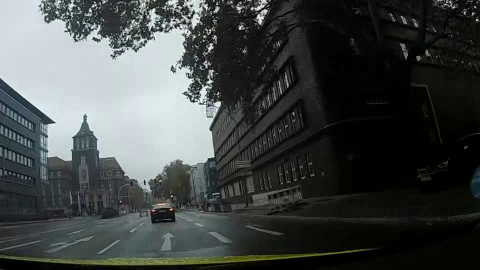

KeyboardInterrupt: 

In [10]:
# Parameter vorhanden: model, cap, writer, _device, CONF_THRES, IOU_THRES, DISPLAY_EVERY, _show, cv2, cap
BATCH_SIZE = 64
frame_idx = 0
frames = []
next_display_at = DISPLAY_EVERY if DISPLAY_EVERY and DISPLAY_EVERY > 0 else None

def process_batch(results, frames, writer, frame_idx):
    last_frame = None
    for res, frm in zip(results, frames):
        boxes = res.boxes
        if boxes and len(boxes) > 0:
            for b in boxes:
                x1, y1, x2, y2 = map(int, b.xyxy[0].tolist())
                conf = float(b.conf[0])
                label = classify_sign(b, frm)
                if label is None:
                    continue
                cv2.rectangle(frm, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frm, label, (x1, max(0, y1-5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
        writer.write(frm)
        frame_idx += 1
        last_frame = frm
    return frame_idx, last_frame


# Frames in Batches lesen und direkt verarbeiten
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

    if len(frames) >= BATCH_SIZE:
        results = model_gtsdb.predict(
            source=frames,
            conf=CONF_THRES_GTSDB,
            iou=IOU_THRES_GTSDB,
            device=_device,
            verbose=False
        )
        frame_idx, last_frame = process_batch(results, frames, writer, frame_idx)

        if next_display_at is not None and frame_idx >= next_display_at:
            _show(last_frame)
            next_display_at += DISPLAY_EVERY

        frames.clear()

# Restbatch
if frames:
    results = model_gtsdb.predict(
        source=frames,
        conf=CONF_THRES_GTSDB,
        iou=IOU_THRES_GTSDB,
        device=_device,
        verbose=False
    )
    frame_idx, last_frame = process_batch(results, frames, writer, frame_idx)

    if next_display_at is not None and frame_idx >= next_display_at:
        _show(last_frame)
        next_display_at += DISPLAY_EVERY

print(f"Fertig: {frame_idx} Frames verarbeitet.")


In [7]:
# Cleanup
cap.release()
writer.release()
cv2.destroyAllWindows()
print(f"Ausgabe gespeichert unter: {OUTPUT_VIDEO}")


Ausgabe gespeichert unter: ..\videos\outputs\Altendorf_270p_short_bboxes.mp4
